# Import required dependencies

In [1]:
import re
import os
import zipfile
import requests
import nltk
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from nltk.corpus import words
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
print(tf.__version__)

2.4.1


In [3]:
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# Prepare dataset and configuration

In [4]:
OUT_OF_VOCABULARY = '<OOV>'
LENGTH_TO_CONSIDER = 30

In [5]:
file_name = 'source_code.txt'
file_url = 'https://github.com/Pittawat2542/dart-ml-autocomplete/raw/master/dataset_collector/source_code.txt'
r = requests.get(file_url, allow_redirects=True)
open(file_name, 'wb').write(r.content)

5148815

In [6]:
dart_keywords = ["abstract", "else", "import", "super", "as", "enum", "in", "switch", "assert", "export", "interface", "sync", "async", "extends", "is", "this", "await", "extension", "library", "throw", "break", "external", "mixin", "true", "case", "factory", "new", "try", "catch", "false", "null", "typedef", "class", "final", "on", "var", "const", "finally", "operator", "void", "continue", "for", "part", "while", "covariant", "Function", "rethrow", "with", "default", "get", "return", "yield", "deferred", "hide", "set", "do", "if", "show", "dynamic", "implements", "static"]
dart_operators = [";", ">", "<", ">=", "<=", "==", "!=", "=", "(", ")", "[", "]", "{", "}", "&&", "||", "!", "&", "|", "^", "~", "++", "--", ".", "?.", "+", "-", "*", "/", "%", "+=", "-=", "*=", "/=", "%=", "~/", ">>", "<<", ">>>", "?", ":", "..", "?..", "^=", "&=", "|=", "??", "=>"]
english_dictionary = words.words()
training_data = open(file_name, 'rb').read().decode(encoding='utf-8')

In [7]:
type_classification_labels = ['KEYWORD', 'OPERATORS', 'SPACE', 'NEWLINE', 'DICTIONARY']

keyword_classification_labels = [w for w in dart_keywords]
keyword_classification_labels.append(OUT_OF_VOCABULARY)

operator_classification_labels = [w for w in dart_operators]
operator_classification_labels.append(OUT_OF_VOCABULARY)

In [8]:
training_data = re.sub(r"//.*", "", training_data) # remove comment
training_data = re.sub(r"import.*", "", training_data) # remove import
training_data = re.sub(r"export.*", "", training_data) # remove export
training_data = re.sub(r"^(?:[\t ]*(?:\r?\n|\r))+", "", training_data) # remove blank line
training_data = re.sub(r"^(\s*\r\n){2,}", "\r\n", training_data) # replace multiple blank lines with one
training_data = re.sub(r"^\s*$", "", training_data) # remove line with only spaces
training_data = training_data.replace('\n', '').replace(';', ';\n')
print(training_data[:250])

final Context posix = Context(style: Style.posix);
final Context windows = Context(style: Style.windows);
final Context url = Context(style: Style.url);
final Context context = createInternal();
Style get style => context.style;
String get current { 


# Prepare dataset for model training

In [9]:
training_data_arr = list(filter(None, re.split(r'( |\n|:|\.|[()])', training_data)))

In [10]:
type_classification_dataset = {
    'Text': [],
    'Label': []
}

for i in range(0, len(training_data_arr) - LENGTH_TO_CONSIDER, 30):
  next_word = training_data_arr[i+LENGTH_TO_CONSIDER]
  label = ''
  if next_word in dart_keywords:
    label = 0
  elif next_word in dart_operators:
    label = 1
  elif next_word == ' ':
    label = 2
  elif next_word == '\n':
    label = 3
  else:
    label = 4
  
  type_classification_dataset['Text'].append(''.join(training_data_arr[i:i+LENGTH_TO_CONSIDER]))
  type_classification_dataset['Label'].append(label)

type_classification_dataset = pd.DataFrame(type_classification_dataset)
type_target = type_classification_dataset.pop('Label')
type_dataset = tf.data.Dataset.from_tensor_slices((type_classification_dataset.values, type_target.values))

In [11]:
keyword_classification_dataset = {
    'Text': [],
    'Label': []
}

training_data_arr_temp = [w for w in training_data_arr]

for i, word in enumerate(training_data_arr_temp):
  if word not in dart_keywords:
    training_data_arr_temp[i] = OUT_OF_VOCABULARY

for i in range(0, len(training_data_arr_temp) - LENGTH_TO_CONSIDER, 30):
  next_word = training_data_arr_temp[i+LENGTH_TO_CONSIDER]
  if next_word != OUT_OF_VOCABULARY:
    keyword_classification_dataset['Text'].append(''.join(training_data_arr_temp[i:i+LENGTH_TO_CONSIDER]))
    keyword_classification_dataset['Label'].append(keyword_classification_labels.index(next_word))

keyword_classification_dataset = pd.DataFrame(keyword_classification_dataset)
keyword_target = keyword_classification_dataset.pop('Label')
keyword_dataset = tf.data.Dataset.from_tensor_slices((keyword_classification_dataset.values, keyword_target.values))

In [12]:
operator_classification_dataset = {
    'Text': [],
    'Label': []
}

training_data_arr_temp = [w for w in training_data_arr]

for i, word in enumerate(training_data_arr_temp):
  if word not in dart_operators:
    training_data_arr_temp[i] = OUT_OF_VOCABULARY

for i in range(0, len(training_data_arr_temp) - LENGTH_TO_CONSIDER, 30):
  next_word = training_data_arr_temp[i+LENGTH_TO_CONSIDER]
  if next_word != OUT_OF_VOCABULARY:
    operator_classification_dataset['Text'].append(''.join(training_data_arr_temp[i:i+LENGTH_TO_CONSIDER]))
    operator_classification_dataset['Label'].append(operator_classification_labels.index(next_word))

operator_classification_dataset = pd.DataFrame(operator_classification_dataset)
operator_target = operator_classification_dataset.pop('Label')
operator_dataset = tf.data.Dataset.from_tensor_slices((operator_classification_dataset.values, operator_target.values))

In [13]:
#@title
dictionary_classification_dataset = {
    'Text': [],
    'Label': []
}

training_data_arr_temp = [w for w in training_data_arr]

for i, word in enumerate(training_data_arr_temp):
  if word in dart_keywords or word in dart_operators or word == ' ' or word == '\n':
    training_data_arr_temp[i] = OUT_OF_VOCABULARY

for i in range(0, len(training_data_arr_temp) - LENGTH_TO_CONSIDER, 30):
  dictionary_classification_dataset['Text'].append(''.join(training_data_arr_temp[i:i+LENGTH_TO_CONSIDER]))
  dictionary_classification_dataset['Label'].append(training_data_arr_temp[i+LENGTH_TO_CONSIDER])

dictionary_classification_dataset = pd.DataFrame(dictionary_classification_dataset)

dictionary_target = dictionary_classification_dataset.pop('Label')

dictionary_dataset = tf.data.Dataset.from_tensor_slices((dictionary_classification_dataset.values, dictionary_target.values))

for feat, targ in dictionary_dataset.take(5):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: [b'<OOV><OOV>Context<OOV>posix<OOV><OOV><OOV>Context<OOV>style<OOV><OOV>Style<OOV>posix<OOV><OOV><OOV><OOV><OOV>Context<OOV>windows<OOV><OOV><OOV>Context<OOV>style'], Target: b'<OOV>'
Features: [b'<OOV><OOV>Style<OOV>windows<OOV><OOV><OOV><OOV><OOV>Context<OOV>url<OOV><OOV><OOV>Context<OOV>style<OOV><OOV>Style<OOV>url<OOV><OOV><OOV><OOV><OOV>Context'], Target: b'<OOV>'
Features: [b'<OOV>context<OOV><OOV><OOV>createInternal<OOV><OOV><OOV><OOV>Style<OOV><OOV><OOV>style<OOV><OOV><OOV>context<OOV>style;<OOV>String<OOV><OOV><OOV>current<OOV><OOV><OOV>'], Target: b'<OOV>'
Features: [b'<OOV><OOV><OOV><OOV><OOV><OOV><OOV><OOV><OOV>Uri<OOV>uri;<OOV><OOV><OOV><OOV><OOV><OOV><OOV><OOV><OOV><OOV>uri<OOV><OOV><OOV>Uri<OOV>base;<OOV>'], Target: b'<OOV>'
Features: [b'<OOV><OOV><OOV><OOV><OOV><OOV>Exception<OOV><OOV><OOV><OOV><OOV><OOV><OOV><OOV><OOV>_current<OOV><OOV><OOV><OOV><OOV><OOV><OOV><OOV>_current!;<OOV><OOV><OOV><OOV>'], Target: b'<OOV>'


# Modeling

In [14]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_' + metric], '')
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [15]:
def plot_loss_acc(history):
  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plot_graphs(history, 'accuracy')
  plt.ylim(None, 1)
  plt.subplot(1, 2, 2)
  plot_graphs(history, 'loss')
  plt.ylim(0, None)

In [16]:
embedding_dim = 32
max_length = LENGTH_TO_CONSIDER
trunc_type='post'
padding_type='post'
oov_tok = '<OOV>'
num_epochs = 30

## Type classification

In [17]:
type_vocab_size = 1000

In [18]:
type_sentences = type_classification_dataset['Text'].tolist()
type_labels = type_target.tolist()

type_training_size = int(len(type_sentences) * 0.8)
type_training_text = type_sentences[:type_training_size]
type_validation_text = type_sentences[type_training_size:]
type_training_labels = np.array(type_labels[:type_training_size])
type_validation_labels = np.array(type_labels[type_training_size:])

In [19]:
type_tokenizer = Tokenizer(num_words=type_vocab_size, oov_token=oov_tok)
type_tokenizer.fit_on_texts(type_training_text)

In [20]:
type_training_sequences = type_tokenizer.texts_to_sequences(type_training_text)
type_training_padded = pad_sequences(type_training_sequences, maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)

In [21]:
type_validation_sequences = type_tokenizer.texts_to_sequences(type_validation_text)
type_validation_padded = pad_sequences(type_validation_sequences, maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

In [22]:
type_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(type_vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(type_classification_labels))
])

type_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
type_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 32)            32000     
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               123008    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 163,589
Trainable params: 163,589
Non-trainable params: 0
_________________________________________________________________


In [23]:
type_history = type_model.fit(type_training_padded, type_training_labels, epochs=num_epochs, validation_data=(type_validation_padded, type_validation_labels))

Epoch 1/30
1261/1261 [==============================] - 5s 4ms/step - loss: 0.8474 - accuracy: 0.6848 - val_loss: 0.6855 - val_accuracy: 0.6846
Epoch 2/30
1261/1261 [==============================] - 4s 3ms/step - loss: 0.6516 - accuracy: 0.7281 - val_loss: 0.6339 - val_accuracy: 0.6841
Epoch 3/30
1261/1261 [==============================] - 4s 3ms/step - loss: 0.5881 - accuracy: 0.7372 - val_loss: 0.6227 - val_accuracy: 0.6839
Epoch 4/30
1261/1261 [==============================] - 4s 3ms/step - loss: 0.5424 - accuracy: 0.7577 - val_loss: 0.6195 - val_accuracy: 0.6839
Epoch 5/30
1261/1261 [==============================] - 4s 3ms/step - loss: 0.5117 - accuracy: 0.7663 - val_loss: 0.6063 - val_accuracy: 0.6900
Epoch 6/30
1261/1261 [==============================] - 4s 3ms/step - loss: 0.4888 - accuracy: 0.7717 - val_loss: 0.6123 - val_accuracy: 0.6820
Epoch 7/30
1261/1261 [==============================] - 4s 3ms/step - loss: 0.4658 - accuracy: 0.7798 - val_loss: 0.6100 - val_accuracy:

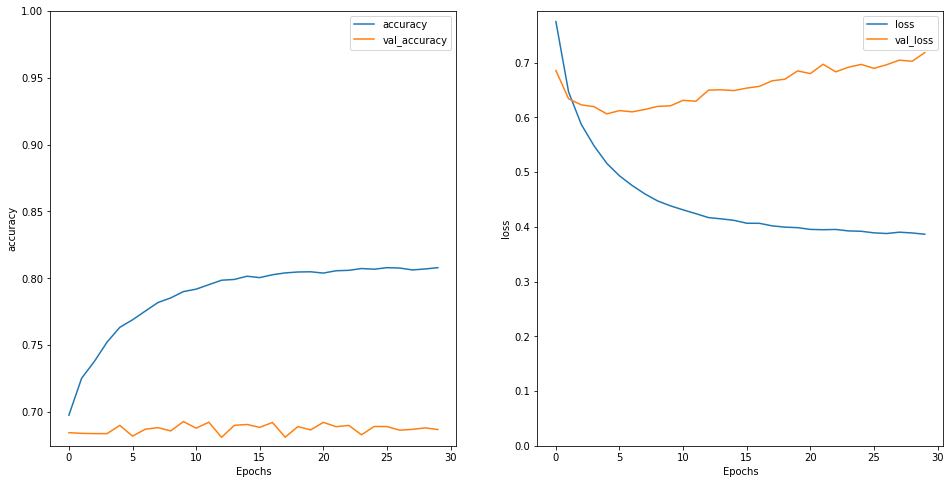

In [24]:
plot_loss_acc(type_history)

In [25]:
type_probability_model = tf.keras.Sequential([type_model, 
                                         tf.keras.layers.Softmax()])

## Keyword classification

In [26]:
keyword_vocab_size = len(dart_keywords) + 1

In [27]:
keyword_sentences = keyword_classification_dataset['Text'].tolist()
keyword_labels = keyword_target.tolist()

keyword_training_size = int(len(keyword_sentences) * 0.8)
keyword_training_text = keyword_sentences[:keyword_training_size]
keyword_validation_text = keyword_sentences[keyword_training_size:]
keyword_training_labels = np.array(keyword_labels[:keyword_training_size])
keyword_validation_labels = np.array(keyword_labels[keyword_training_size:])

In [28]:
keyword_tokenizer = Tokenizer(num_words=keyword_vocab_size, oov_token=oov_tok)
keyword_tokenizer.fit_on_texts(keyword_training_text)

In [29]:
keyword_training_sequences = keyword_tokenizer.texts_to_sequences(keyword_training_text)
keyword_training_padded = pad_sequences(keyword_training_sequences, maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)

In [30]:
keyword_validation_sequences = keyword_tokenizer.texts_to_sequences(keyword_validation_text)
keyword_validation_padded = pad_sequences(keyword_validation_sequences, maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

In [31]:
keyword_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(keyword_vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(keyword_vocab_size)
])

keyword_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
keyword_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 32)            1984      
_________________________________________________________________
flatten_1 (Flatten)          (None, 960)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               123008    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 62)                4030      
Total params: 137,278
Trainable params: 137,278
Non-trainable params: 0
_________________________________________________________________


In [32]:
keyword_history = keyword_model.fit(keyword_training_padded, keyword_training_labels, epochs=num_epochs, validation_data=(keyword_validation_padded, keyword_validation_labels))

Epoch 1/30
13/13 [==============================] - 1s 21ms/step - loss: 4.0439 - accuracy: 0.1931 - val_loss: 3.6063 - val_accuracy: 0.0000e+00
Epoch 2/30
13/13 [==============================] - 0s 7ms/step - loss: 3.2649 - accuracy: 0.3526 - val_loss: 2.9187 - val_accuracy: 0.0000e+00
Epoch 3/30
13/13 [==============================] - 0s 7ms/step - loss: 2.6923 - accuracy: 0.3434 - val_loss: 2.1787 - val_accuracy: 0.0000e+00
Epoch 4/30
13/13 [==============================] - 0s 7ms/step - loss: 2.3157 - accuracy: 0.3754 - val_loss: 2.3672 - val_accuracy: 0.0000e+00
Epoch 5/30
13/13 [==============================] - 0s 7ms/step - loss: 2.3501 - accuracy: 0.3395 - val_loss: 2.3318 - val_accuracy: 0.0000e+00
Epoch 6/30
13/13 [==============================] - 0s 7ms/step - loss: 2.3494 - accuracy: 0.3336 - val_loss: 2.2886 - val_accuracy: 0.0000e+00
Epoch 7/30
13/13 [==============================] - 0s 6ms/step - loss: 2.2719 - accuracy: 0.3590 - val_loss: 2.2892 - val_accuracy: 0.

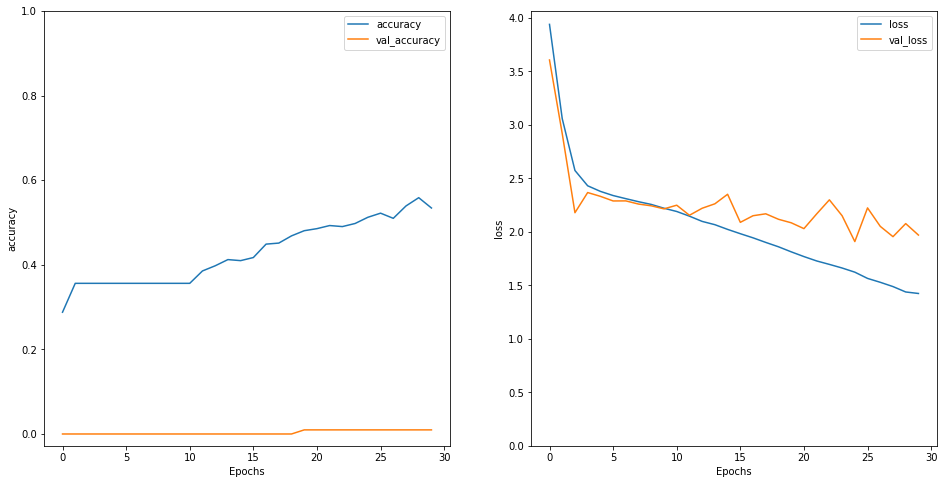

In [33]:
plot_loss_acc(keyword_history)

In [34]:
keyword_probability_model = tf.keras.Sequential([keyword_model, 
                                         tf.keras.layers.Softmax()])

## Operator classification

In [35]:
operator_vocab_size = len(dart_operators) + 1

In [36]:
operator_sentences = operator_classification_dataset['Text'].tolist()
operator_labels = operator_target.tolist()

operator_training_size = int(len(operator_sentences) * 0.8)
operator_training_text = operator_sentences[:operator_training_size]
operator_validation_text = operator_sentences[operator_training_size:]
operator_training_labels = np.array(operator_labels[:operator_training_size])
operator_validation_labels = np.array(operator_labels[operator_training_size:])

In [37]:
operator_tokenizer = Tokenizer(num_words=operator_vocab_size, oov_token=oov_tok)
operator_tokenizer.fit_on_texts(operator_training_text)

In [38]:
operator_training_sequences = operator_tokenizer.texts_to_sequences(operator_training_text)
operator_training_padded = pad_sequences(operator_training_sequences, maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)

In [39]:
operator_validation_sequences = operator_tokenizer.texts_to_sequences(operator_validation_text)
operator_validation_padded = pad_sequences(operator_validation_sequences, maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

In [40]:
operator_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(operator_vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(operator_vocab_size)
])

operator_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
operator_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 32)            1568      
_________________________________________________________________
flatten_2 (Flatten)          (None, 960)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               123008    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 49)                3185      
Total params: 136,017
Trainable params: 136,017
Non-trainable params: 0
_________________________________________________________________


In [41]:
operator_history = operator_model.fit(operator_training_padded, operator_training_labels, epochs=num_epochs, validation_data=(operator_validation_padded, operator_validation_labels))

Epoch 1/30
166/166 [==============================] - 1s 4ms/step - loss: 2.3955 - accuracy: 0.2779 - val_loss: 1.5536 - val_accuracy: 0.4223
Epoch 2/30
166/166 [==============================] - 1s 3ms/step - loss: 1.5682 - accuracy: 0.4271 - val_loss: 1.3166 - val_accuracy: 0.5075
Epoch 3/30
166/166 [==============================] - 1s 3ms/step - loss: 1.3859 - accuracy: 0.4987 - val_loss: 1.2691 - val_accuracy: 0.5317
Epoch 4/30
166/166 [==============================] - 1s 4ms/step - loss: 1.4048 - accuracy: 0.4884 - val_loss: 1.2505 - val_accuracy: 0.5445
Epoch 5/30
166/166 [==============================] - 1s 3ms/step - loss: 1.3637 - accuracy: 0.5025 - val_loss: 1.2248 - val_accuracy: 0.5204
Epoch 6/30
166/166 [==============================] - 1s 4ms/step - loss: 1.3769 - accuracy: 0.5036 - val_loss: 1.2292 - val_accuracy: 0.5626
Epoch 7/30
166/166 [==============================] - 1s 3ms/step - loss: 1.3425 - accuracy: 0.5074 - val_loss: 1.1973 - val_accuracy: 0.5317
Epoch 

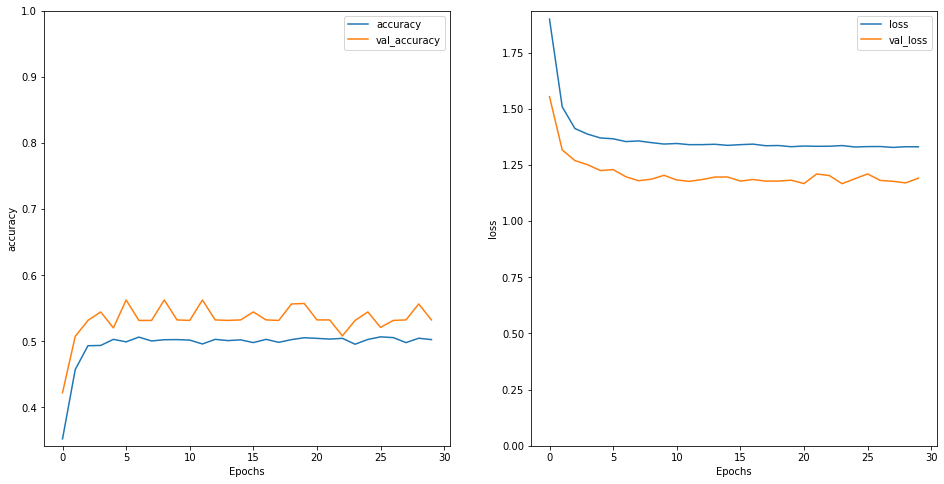

In [42]:
plot_loss_acc(operator_history)

In [43]:
operator_probability_model = tf.keras.Sequential([keyword_model, 
                                         tf.keras.layers.Softmax()])

## Exporting models

In [ ]:
def zipdir(path, ziph):
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file), 
                       os.path.relpath(os.path.join(root, file), 
                                       os.path.join(path, '..')))

In [44]:
type_probability_model.save('type_model')

INFO:tensorflow:Assets written to: type_model/assets


In [ ]:
zipf = zipfile.ZipFile('type_model.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('type_model/', zipf)

In [46]:
keyword_probability_model.save('keyword_model')

INFO:tensorflow:Assets written to: keyword_model/assets


In [ ]:
zipf = zipfile.ZipFile('keyword_model.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('keyword_model/', zipf)

In [47]:
operator_probability_model.save('operator_model')

INFO:tensorflow:Assets written to: operator_model/assets


In [48]:
zipf = zipfile.ZipFile('operator_model.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('operator_model/', zipf)

In [ ]:
zipf.close()

## Combining result

In [ ]:
# Weighted combine every things and show top ten

In [ ]:
sample_sequences = type_tokenizer.texts_to_sequences(['const goodBoy = Complex();'])
test_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)

In [ ]:
predictions = type_probability_model.predict(test_padded)
type_classification_labels[np.argmax(predictions)]

In [ ]:
sample_sequences = keyword_tokenizer.texts_to_sequences(['const goodBoy = Complex();'])
test_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)

In [ ]:
predictions = keyword_probability_model.predict(test_padded)
keyword_classification_labels[np.argmax(predictions)]

In [ ]:
sample_sequences = operator_tokenizer.texts_to_sequences(['const goodBoy = Complex();'])
test_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)

In [ ]:
predictions = operator_probability_model.predict(test_padded)
operator_classification_labels[np.argmax(predictions)]

In [49]:
def download_and_unzip(file_name, url):
  r = requests.get(url, allow_redirects=True)
  open(file_name, 'wb').write(r.content)

  zip_ref = zipfile.ZipFile(file_name, "r")
  zip_ref.extractall()
  zip_ref.close()

In [65]:
def predict_next_n_words(text, n):
  download_and_unzip('type_model_v1.zip', 'https://github.com/Pittawat2542/dart-ml-autocomplete/raw/master/type_model_v1.zip')
  download_and_unzip('keyword_model_v1.zip', 'https://github.com/Pittawat2542/dart-ml-autocomplete/raw/master/keyword_model_v1.zip')
  download_and_unzip('operator_model_v1.zip', 'https://github.com/Pittawat2542/dart-ml-autocomplete/raw/master/operator_model_v1.zip')

  loaded_type_model = tf.keras.models.load_model('type_model')
  loaded_keyword_model = tf.keras.models.load_model('keyword_model')
  loaded_operator_model = tf.keras.models.load_model('operator_model')
  
  t = list(filter(None, re.split(r'( |\n|:|\.|[()])', text)))
  for i in range(n):
    input_text = ''.join(t)
    sequences = type_tokenizer.texts_to_sequences([input_text])
    padded = pad_sequences(sequences, padding=padding_type, maxlen=max_length)
    predicted_type = type_classification_labels[np.argmax(loaded_type_model.predict(padded))]

    next_word = ''
    if predicted_type == 'SPACE':
      next_word = ' '
    elif predicted_type == 'NEWLINE':
      next_word = '\n'
    elif predicted_type == 'KEYWORD':
      sequences = keyword_tokenizer.texts_to_sequences([input_text])
      padded = pad_sequences(sequences, padding=padding_type, maxlen=max_length)
      next_word = keyword_classification_labels[np.argmax(loaded_keyword_model.predict(padded))]
    elif predicted_type == 'OPERATORS':
      sequences = operator_tokenizer.texts_to_sequences([input_text])
      padded = pad_sequences(sequences, padding=padding_type, maxlen=max_length)
      next_word = operator_classification_labels[np.argmax(loaded_operator_model.predict(padded))]
    else:
      next_word = OUT_OF_VOCABULARY
    
    t.append(next_word)

  return ''.join(t)

# Predicting

In [67]:
predict_next_n_words('const icon = IconData(', 1)

'const icon = IconData(this'